## Currently this notebook is an illustration for Adonis.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import ClassicalRegister
from iqm.qiskit_iqm.fake_backends.fake_adonis import IQMFakeAdonis
from iqm.benchmarks.entanglement.graph_states import generate_graph_state
from iqm.benchmarks.shadow_utils import *
from qiskit import ClassicalRegister, transpile
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

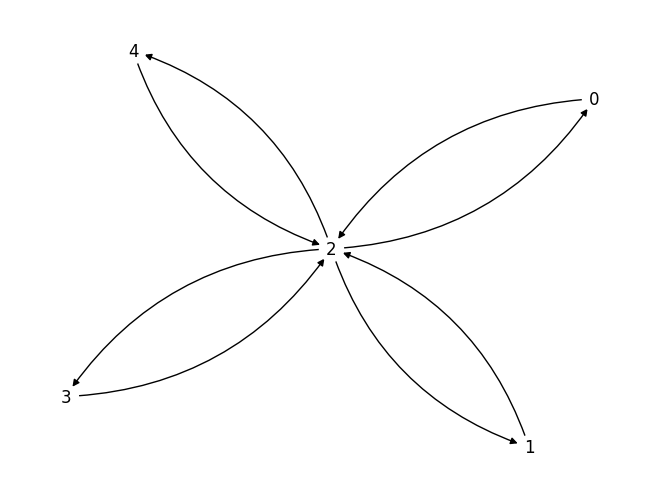

In [6]:
## initiate the backend
backend = IQMFakeAdonis()
mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color='w', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

In [7]:
qc = generate_graph_state(list(range(backend.num_qubits)), backend=backend)
sub_system = list(backend.coupling_map)
sub_system = [v for i, v in enumerate(sub_system) if i % 2 == 0]
sub_system = [list(x) for x in sub_system]

groups = [list(set(list(range(backend.num_qubits))) - set(x)) for x in sub_system]
num_group = len(groups)

## given the quantum circuit, the neighbouring qubits are measured in the z basis
## For Adnois this forms 4 such groups.
def project_neighbouring_qubits(qc, num_cregs, meas_qubit):
    qc_copy = qc.copy()
    qc_copy.barrier()
    register = ClassicalRegister(num_cregs)
    qc_copy.add_register(register)
    for idx, iq in enumerate(meas_qubit):
        qc_copy.measure(iq, register[idx])
    return qc_copy

neighbour_qubits = 3
qc_list = [project_neighbouring_qubits(qc, neighbour_qubits, x) for x in groups]

In [8]:
Nu = 50 ## number of random unitaries used
Nm = 1000 ## number of measurements per random unitary
counts_list = []
unitaries_list = []
for circs in qc_list:
    unitaries, rm_circs = haar_shadow_tomography(circs, Nu, list(range(backend.num_qubits)))
    rm_trans = [optimize_single_qubit_gates(transpile(qcc, backend), drop_final_rz=True) for qcc in rm_circs]

    job = backend.run(rm_trans, shots = Nm)  
    counts = job.result().get_counts()
    counts_list.append(counts)
    unitaries_list.append(unitaries)

In [10]:
neigbour_bit_strings = [' ' + format(x, '0'+str(neighbour_qubits)+'b') for x in range(2**neighbour_qubits)] # list of strings of the remaining 3 neighbouring qubits
counts_bit = [] ## counts of the edge of interest in the graph for all possible combination of the neighbouring qubits

for ibit in neigbour_bit_strings:
    counts_group = []
    for iu in range(len(groups)):
        counts_per_batch = []
        for iq in range(len(counts_list[iu])):
            counts_new = {}
            for inm, ist in enumerate(counts_list[iu][iq].keys()):
                if (ist[-4:] == ibit):
                    counts_new[ist[0:5]] = counts_list[iu][iq][ist]
            counts_per_batch.append(counts_new)
        counts_group.append(counts_per_batch)
    counts_bit.append(counts_group)

In [11]:
## construct shadows for each neighbour_bit_string and each edge of interest.
rho_shadows_all_bits = []

for idx, ibit in enumerate(neigbour_bit_strings):
    rho_shadows = []
    for ib in range(len(groups)):
        nqubits = len(sub_system[ib])
        rho = np.zeros((2**nqubits, 2**nqubits), dtype = complex)
        for iu in range(Nu):
            rho += get_shadow(counts_bit[idx][ib][iu], unitaries_list[ib][iu,:,:,:], sub_system[ib])/Nu
        rho_shadows.append(rho)
    rho_shadows_all_bits.append(rho_shadows)

Text(0.5, 0, 'Edges')

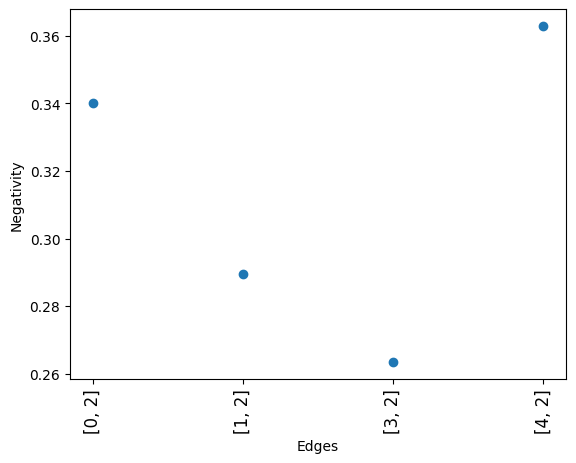

In [12]:
## compute the 2 qubit negativity for each of the neighbour bitstrings and groups
neg = [[np.abs(get_negativity(rho_shadows_all_bits[bits][isys], 1, 1)) for bits in range(2**neighbour_qubits)] for isys in range(num_group)]
neg_per_edge = [max(x) for x in neg]
plt.scatter(list(range(num_group)), neg_per_edge)
plt.xticks(list(range(num_group)), sub_system, fontsize=12, rotation=90)
plt.ylabel('Negativity')
plt.xlabel('Edges')